# Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
np.random.seed(13)

In [0]:
# Download data in google colab, no need to run this in your laptops

# Just in case...
!rm -rf ml-latest-small*
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2019-04-06 05:44:20--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.10MB/s    in 0.3s    

2019-04-06 05:44:20 (3.10 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


# Load data

In [0]:
rating_data = pd.read_csv("ml-latest-small/ratings.csv", index_col='timestamp', parse_dates=['timestamp'], date_parser = lambda x: datetime.datetime.fromtimestamp(int(x)))
movie_data = pd.read_csv("ml-latest-small/movies.csv", index_col='movieId')

## Process data
**Assumption**: one rating = one request

In [0]:
del rating_data['userId']
rating_data.head()

,movieId,rating
timestamp,,
2000-07-30 18:45:03,1,4.0
2000-07-30 18:20:47,3,4.0
2000-07-30 18:37:04,6,4.0
2000-07-30 19:03:35,47,5.0
2000-07-30 18:48:51,50,5.0


In [0]:
del movie_data['title']
movie_data.head()

,genres
movieId,
1,Adventure|Animation|Children|Comedy|Fantasy
2,Adventure|Children|Fantasy
3,Comedy|Romance
4,Comedy|Drama|Romance
5,Comedy


In [0]:
def assign_class(n_req, total_req):
    """
    assign class based on the no. of request received
    """
    
    # top 1% of the day are Class 1
    if n_req > 0.01 * total_req:
        return 1
    # top 0.5% of the day are Class 2
    elif n_req > 0.005 * total_req:
        return 2
    # top 0.01% of the day are Class 3
    elif n_req > 0.001 * total_req:
        return 3
    # rest are Class 4
    else:
        return 4

In [0]:
def group_movies(daywise_group):
    """
    add request probablity to input pandas DataFrame
    
    :param daywise_group: a DataFrame containing movieId and corresponding ratings for a single day.
    """

    df = daywise_group.groupby("movieId").count()   
    # `rating` column now holds the no. of requests, so rename the column to avoid confusion
    df.rename(columns={"rating":"req"}, inplace=True)
    df['totalReq'] = daywise_group.shape[0]
    # request probablity for that day
    df['reqProb'] = daywise_group.groupby("movieId").count()['rating'] / df['totalReq']
    return df

In [113]:
grouped_by_movie = rating_data.resample("1y").apply(group_movies)
# grouped_by_movie['class'] = grouped_by_movie[['req', 'totalReq']].apply(lambda x:assign_class(x['req'], x['totalReq']), axis=1)
grouped_by_movie.reset_index(level='movieId', inplace=True)
grouped_by_movie.head()

,movieId,req,totalReq,reqProb
timestamp,,,,
1996-12-31,1,33,6040,0.005464
1996-12-31,2,26,6040,0.004305
1996-12-31,3,12,6040,0.001987
1996-12-31,4,5,6040,0.000828
1996-12-31,5,18,6040,0.002980


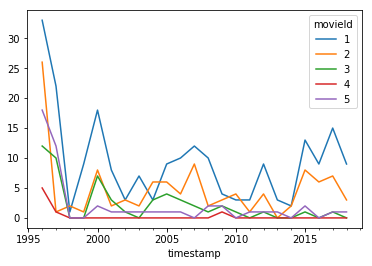

In [114]:
grouped_by_movie.pivot(columns='movieId', values='req').fillna(0).iloc[:100,:5].plot()

### Add genres

In [115]:
grouped_by_movie = pd.merge(grouped_by_movie.reset_index(), movie_data.reset_index())
grouped_by_movie.set_index('timestamp', inplace = True)
grouped_by_movie.head()

,movieId,req,totalReq,reqProb,genres
timestamp,,,,,
1996-12-31,1,33,6040,0.005464,Adventure|Animation|Children|Comedy|Fantasy
1997-12-31,1,22,1916,0.011482,Adventure|Animation|Children|Comedy|Fantasy
1998-12-31,1,1,507,0.001972,Adventure|Animation|Children|Comedy|Fantasy
1999-12-31,1,9,2439,0.003690,Adventure|Animation|Children|Comedy|Fantasy
2000-12-31,1,18,10061,0.001789,Adventure|Animation|Children|Comedy|Fantasy


In [116]:
# Convert genres(str) to a binary matrix
# because string are good for humans but
# machines like numbers!
from sklearn.preprocessing import MultiLabelBinarizer
splitted = grouped_by_movie['genres'].apply(lambda x:x.split("|"))
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(splitted)

genre_df = pd.DataFrame(genre_matrix)

with_genre = pd.merge(grouped_by_movie.reset_index(), genre_df.reset_index(), left_index=True, right_index=True)
del with_genre['genres'], with_genre['index']

# shift class column to the end
with_genre = with_genre[ list(filter(lambda x: x!='req', with_genre.columns)) + ['req']]

with_genre.set_index('timestamp', inplace = True)
with_genre.head()

,movieId,totalReq,reqProb,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,req
timestamp,,,,,,,,,,,,,,,,,,,,,
1996-12-31,1,6040,0.005464,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,33
1997-12-31,1,1916,0.011482,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,22
1998-12-31,1,507,0.001972,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1999-12-31,1,2439,0.003690,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,9
2000-12-31,1,10061,0.001789,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,18


In [119]:
# We are selecting a single movie here, selecting 
# multiple movies will yield bad results because 
# of difference in data points.
movie_history = with_genre.copy()
movie_history = movie_history.reset_index().sort_values(['movieId','timestamp'])
movie_history['Y'] = np.roll(movie_history['req'], -1)
movie_history.set_index('timestamp', inplace=True)
# movie_history.pivot(columns='movieId', values='req').plot(kind='bar', title="Request Counts/day")
del movie_history['totalReq']
del movie_history['movieId']
movie_history.head()

,reqProb,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,req,Y
timestamp,,,,,,,,,,,,,,,,,,,,,
1996-12-31,0.005464,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,33,22
1997-12-31,0.011482,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,22,1
1998-12-31,0.001972,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,9
1999-12-31,0.003690,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,9,18
2000-12-31,0.001789,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,18,8


In [156]:
mlb.classes_

array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype=object)

# Crunching numbers!

In [120]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

values = movie_history.values
# #print(values)
# one_hot_encoded = np.concatenate((list(map(lambda x:np.eye(4)[x-1], values[:,23].astype('int')) ),
#                list(map(lambda x:np.eye(4)[x-1], values[:,24].astype('int')))), axis=1)
# values = np.concatenate((movie_history.values[:,:23], one_hot_encoded), axis=1)

# Scale 
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
scaled_values.shape


(41295, 23)

## Make X and Y

In [122]:
n_input_cols = 22
n_output_cols = 1
X = scaled_values[:,:n_input_cols]
y = scaled_values[:,n_input_cols:]
# reshape
# X = X.reshape(X.shape[0], 1, n_input_cols)
# y = y.reshape(y.shape[0], 1, n_output_cols)
print(X.shape)
print(y.shape)

(41295, 22)
(41295, 1)


## train_test_split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Make Model

In [145]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [179]:
prediction = model.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(prediction, y_test)

0.0005245930375970183

In [180]:
def predict(input_array):
    dat = np.concatenate((input_array, [[0]*n_output_cols]*input_array.shape[0]), axis=1)
    dat = scaler.transform(dat)[:,:n_input_cols]
    predicted = model.predict(dat)

    predicted = predicted.reshape(1,n_output_cols)
    x = np.concatenate(([[0]*n_input_cols]*input_array.shape[0], predicted), axis=1)
    return scaler.inverse_transform(x)[:,n_input_cols:]

predict(np.array([
    [0.156] + list(mlb.transform([['Comedy', 'Sci-Fi']])[0]) + [5]
]))

array([[4.13237482]])